In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils import data
import numpy as np
import matplotlib.pyplot as plt
import os
import cProfile, pstats, io
from pstats import SortKey
from random import randint
from Utillities import Utillities
from cnn_model import CNN6     


print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

if os.path.exists("checkpoint.pt"):
    os.remove("checkpoint.pt")

torch.manual_seed(10)   # reproducible

OPTIMIZATION_PLUGIN = 'GradDescent' # 'Bayesian' or 'Scikit' or 'GradDescent'
#Bayesian requires: $ conda install -c conda-forge bayesian-optimization

GET_STATS = False
GPU_SELECT = 2 # can be 0, 1, 2 (both)
PARALLEL_PROCESSES = 2
TRIALS = 10000
RANDOM_STARTS = 10000
LR  = 1e-5                    # learning rate
SCI_LR =  1e-5
LR2 = 1e-5
SCI_MM = 0.5                  # momentum - used only with SGD optimizer
MM = 0.5
L_FIRST = 24                  # initial number of channels
KERNEL_X = 24
patience = 21                 # if validation loss not going down, wait "patience" number of epochs
accuracy = 0
MaxCredit = -800

CreditVector = np.zeros(RANDOM_STARTS + TRIALS)
CreditVector = CreditVector - 800
CreditVec = np.zeros(RANDOM_STARTS + TRIALS)
count = 0

pr = cProfile.Profile()

if GET_STATS:
    pr.enable()
    

if GPU_SELECT == 2:
    if torch.cuda.device_count() > 1:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("Using", torch.cuda.device_count(), "NVIDIA 1080TI GPUs!")

if GPU_SELECT == 1:
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")    
    print("Using one (the second) NVIDIA 1080TI GPU!")

if GPU_SELECT == 0:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")       
    print("Using one (the first) NVIDIA 1080TI GPU!")


PyTorch Version:  1.2.0
Torchvision Version:  0.4.0a0+6b959ee
Using 2 NVIDIA 1080TI GPUs!


In [2]:
from early_stopping import EarlyStopping
from dataset import dataset


early_stopping = EarlyStopping(patience=patience, verbose=True)  # initialize the early_stopping object

# Counter for the execution time
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

In [3]:
if OPTIMIZATION_PLUGIN == 'Scikit' :
    from skopt import gp_minimize
    from sklearn.datasets import load_boston
    from sklearn.ensemble import GradientBoostingRegressor
    from sklearn.model_selection import cross_val_score
    from skopt.space import Real, Integer
    from skopt.utils import use_named_args
    from skopt.plots import plot_convergence
    from functools import partial
    from skopt.plots import plot_evaluations
    from skopt import gp_minimize, forest_minimize, dummy_minimize, gbrt_minimize
    from skopt.plots import plot_objective
    from sklearn.preprocessing import LabelEncoder
    from skopt.space import Real, Categorical, Integer
    from sklearn.externals.joblib import Parallel, delayed

    SCI_LR = Categorical(categories=[1e-1, 3e-1, 5e-1, 7e-1, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.08, 0.09],name= 'SCI_LR')
    SCI_MM = Categorical(categories=[0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 0.999], name='SCI_MM')
    SCI_REGULARIZATION = Categorical(categories=[0.0001, 0.0003, 0.0007, 0.001, 0.003, 0.007, 0.01, 0.03, 0.07, 0.1, 0.3, 0.7], name='SCI_REGULARIZATION')
    SCI_EPOCHS = Categorical(categories=[2000, 1000], name='SCI_EPOCHS')
    SCI_optimizer = Categorical(categories=['Adam', 'AMSGrad', 'SGD', 'RMSprop', 'Rprop', 'AdamW', 'ASGD', 'Adadelta', 'Adamax'],name='SCI_optimizer') #
    SCI_loss_type = Categorical(categories=['CrossEntropyLoss', 'MultiMarginLoss','NLLLoss', 'L1Loss'],name='SCI_loss_type') # 
    SCI_BATCH_SIZE = Categorical(categories=[4, 8, 12, 16, 24, 32, 48, 64, 80, 96, 104, 128, 144, 160, 192, 224, 256], name='SCI_BATCH_SIZE')
    SCI_DROPOUT = Categorical(categories=[0, 0.01, 0.03, 0.07, 0.1, 0.13, 0.17, 0.2, 0.23, 0.27, 0.3, 0.33, 0.37, 0.4] , name = 'SCI_DROPOUT')
    SCI_RELU = Categorical(categories=['True', 'False'] , name = 'SCI_RELU')
    SCI_BIAS = Categorical(categories=['True', 'False'] , name = 'SCI_BIAS')
    SCI_L_SECOND = Categorical(categories=[2, 4, 6, 8, 12, 16, 20, 24, 32, 48, 64], name='SCI_L_SECOND')
    SCI_BN_MOMENTUM = Categorical(categories=[0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99] , name = 'SCI_BN_MOMENTUM') 
    SCI_SGD_MOMENTUM = Categorical(categories=[0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99] , name = 'SCI_SGD_MOMENTUM') 
    SCI_LINEARITY = Categorical(categories=[1, 2],name= 'SCI_LINEARITY')
   

    dimensions = [SCI_BATCH_SIZE, SCI_MM, SCI_REGULARIZATION, SCI_optimizer, SCI_LR, SCI_loss_type, SCI_DROPOUT, SCI_RELU, SCI_BIAS, SCI_L_SECOND, SCI_EPOCHS, SCI_BN_MOMENTUM, SCI_SGD_MOMENTUM, SCI_LINEARITY]

    @use_named_args(dimensions = dimensions)

    def objective(SCI_BATCH_SIZE, SCI_MM, SCI_REGULARIZATION, SCI_optimizer, SCI_LR, SCI_loss_type, SCI_DROPOUT, SCI_RELU, SCI_BIAS, SCI_L_SECOND, SCI_EPOCHS, SCI_BN_MOMENTUM, SCI_SGD_MOMENTUM, SCI_LINEARITY):
        global device  

        loss_func = nn.CrossEntropyLoss()

        def create_loss(LOSS):   
            if LOSS == 'CrossEntropyLoss':
                loss_func = nn.CrossEntropyLoss()
            if LOSS == 'NLLLoss':
                loss_func = nn.NLLLoss()
            else:
                loss_func = nn.MultiMarginLoss()
            return loss_func

        MM = float(str(SCI_MM))
        REGULARIZATION = float(str(SCI_REGULARIZATION))
        optimizer = str(SCI_optimizer)
        LR = float(str(SCI_LR))
        train_losses = []         # to track the training loss as the model trains
        output = 0
        loss = 0
        accuracy = 0
        early_stopping.counter = 0
        early_stopping.best_score = None
        early_stopping.early_stop = False
        early_stopping.verbose = False  
        TEST_RESULTS = torch.zeros(1,2)
 
        loss_type = create_loss(SCI_loss_type)
                
        cnn = CNN6(L_FIRST, SCI_L_SECOND, KERNEL_X, SCI_BIAS, SCI_BN_MOMENTUM, SCI_RELU, SCI_DROPOUT, dataset.CLASSES, SCI_LINEARITY)     

        optimizer = Utillities.optimization_algorithms(SCI_optimizer,cnn, SCI_LR, SCI_SGD_MOMENTUM,
                                                       SCI_REGULARIZATION)
        
        if GPU_SELECT == 2:
            if torch.cuda.device_count() > 1:
                cnn = nn.DataParallel(cnn,device_ids=[0, 1], dim=0) 
            cnn = cnn.cuda()
        if GPU_SELECT == 1:
            cnn.to(device)  
        if GPU_SELECT == 0:
            cnn.to(device)        

        cnn.apply(CNN6.weights_reset)
        cnn.share_memory()
     

        Utillities.listing(optimizer, SCI_SGD_MOMENTUM, SCI_BN_MOMENTUM, SCI_L_SECOND, SCI_LR, SCI_RELU, SCI_BIAS, SCI_loss_type, REGULARIZATION, SCI_BATCH_SIZE, SCI_DROPOUT, SCI_LINEARITY)
    
        #SCI_BATCH_SIZE = 1
        # Data Loader for easy mini-batch return in training
        SCI_BATCH_SIZE = int(SCI_BATCH_SIZE)
        train_loader = Data.DataLoader(dataset = dataset.train_dataset, batch_size = SCI_BATCH_SIZE, shuffle = False, num_workers = 0, drop_last=True, pin_memory=True)
        validation_loader = Data.DataLoader(dataset = dataset.validation_dataset, batch_size = SCI_BATCH_SIZE, shuffle = False, num_workers = 0, drop_last=True, pin_memory=True)    
        test_loader = Data.DataLoader(dataset = dataset.test_dataset, batch_size = SCI_BATCH_SIZE, shuffle = False, num_workers = 0, pin_memory=True)
    
        for epoch in range(SCI_EPOCHS):
            loss = None        
            cnn.train().cuda()
            for step, (train_data, train_target) in enumerate(train_loader):   
                train_data, train_target = train_data.to(device), train_target.to(device)
                output, temp = cnn(train_data)                # forward pass: compute predicted outputs by passing inputs to the model     
                loss = loss_func(output, train_target)
                train_losses.append(loss.item())              # record training loss 
                loss.backward()                               # backward pass: compute gradient of the loss with respect to model parameters
                optimizer.zero_grad()
                optimizer.step()                              # perform a single optimization step (parameter update)
      
            cnn.eval().cuda()                 # switch to evaluation (no change) mode           
            valid_loss = 0
            accuracy = 0
            with torch.no_grad():
                for step, (validation_data, validation_target) in enumerate(validation_loader):
                    validation_data, validation_target = validation_data.to(device), validation_target.to(device)
                    output, temp = cnn(validation_data)            # forward pass: compute predicted outputs by passing inputs to the model
                    valid_loss += loss_func(output, validation_target).item()
                    #ps = torch.exp(output)
                    #equality = (validation_target[0].data == ps.max(dim=1)[1])
                    #accuracy += equality.type(torch.FloatTensor).mean()      
               
            train_losses = []
            early_stopping(valid_loss, cnn)
       
            if early_stopping.early_stop:
                if os.path.exists('checkpoint.pt'):
                    print("Loaded the model with the lowest Validation Loss!")
                    #nn.load_state_dict(torch.load('checkpoint.pt', map_location="cuda:1"))  # Choose whatever GPU device number you want
                    cnn.load_state_dict(torch.load('checkpoint.pt', map_location="cuda:1"))  # Choose whatever GPU device number you want
                    cnn.to(device)
                break
      
        cnn.eval()
        class_correct = list(0. for i in range(1000))
        class_total = list(0. for i in range(1000))
        with torch.no_grad():
            for (test_data, test_target) in test_loader:
                test_data, test_target = test_data.to(device), test_target.to(device)
                outputs, temp = cnn(test_data)
                _, predicted = torch.max(outputs, 1)
                c = (predicted == test_target).squeeze()
                for i in range(test_target.size(0)):
                    label = test_target[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1

        for i in range(dataset.CLASSES):
            TEST_RESULTS[0,i] = class_correct[i] / dataset.TESTED_ELEMENTS[i]
            print('Class: ',i,' accuracy: ', TEST_RESULTS[0,i])
            print('Class: ',i,' correct: ', class_correct[i])
        percent = (TEST_RESULTS[0,0]+TEST_RESULTS[0,1])/2
        print('Final percentage: ',percent)
    
        CreditCost = int((1 - TEST_RESULTS[0,0]) * dataset.TESTED_ELEMENTS[0] + (1 - TEST_RESULTS[0,1]) * dataset.TESTED_ELEMENTS[1] * 5)
    
        if TEST_RESULTS[0,0] == 0 or TEST_RESULTS[0,1] == 0 :
            CreditCost = CreditCost + 300
    
        print('Last epoch: ', epoch)
        print('Credit Cost: ',CreditCost)
    
        if os.path.exists('checkpoint.pt'):  
            os.remove('checkpoint.pt') 

        print()
        torch.cuda.empty_cache()
        print()
        
        return CreditCost
    
    #not working #res_gp = gp_minimize(objective, dimensions=dimensions, n_calls=TRIALS, random_state=1, verbose=True, acq_func='gp_hedge', acq_optimizer='auto', n_jobs=1)
    res_gp = forest_minimize(objective, dimensions=dimensions, base_estimator='RF', n_calls=TRIALS, n_random_starts=RANDOM_STARTS, acq_func='EI', x0=None, y0=None, random_state=None, verbose=True, callback=None, n_points=10000, xi=0.01, kappa=1.5, n_jobs=4)
    #res_gp = gbrt_minimize(objective, dimensions=dimensions, base_estimator='ET', n_calls=TRIALS+RANDOM_STARTS, n_random_starts=RANDOM_STARTS, acq_func='LCB', x0=None, y0=None, random_state=None, verbose=True, callback=None, n_points=100, xi=0.01, kappa=1.96, n_jobs=1)
    #res_gp = dummy_minimize(objective, dimensions=dimensions, n_calls=TRIALS, x0=None, y0=None, random_state=None, verbose=True, callback=None)      

    "Best score=%.4f" % res_gp.fun
    print("""Best parameters: - optimization=%d""" % (res_gp.x[0]))
  
    print(res_gp)
    plot_convergence(res_gp)
    #plot_evaluations(res_gp)
    #plot_objective(res_gp)
    

In [4]:


if OPTIMIZATION_PLUGIN == 'Bayesian' :
    from bayes_opt import BayesianOptimization
    
    #def black_box_function(x, y):
    def objective(SCI_RELU, SCI_BIAS, SCI_loss_type,
                  SCI_optimizer, SCI_LR, SCI_MM, 
                  SCI_REGULARIZATION, SCI_EPOCHS, SCI_BATCH_SIZE, 
                  SCI_DROPOUT, SCI_L_SECOND, SCI_BN_MOMENTUM, SCI_SGD_MOMENTUM, SCI_LINEARITY):
        #global device, MaxCredit  , SCI_REGULARIZATION, SCI_DROPOUT, SCI_L_SECOND, SCI_EPOCHS, SCI_BN
        global count, CreditVector, CreditVec, device, MaxCredit

        
        SCI_BATCH_SIZE = int(SCI_BATCH_SIZE)                    # integer between 4 and 256
        SCI_MM = round(SCI_MM,3)                                # real with three decimals between (0.001, 0.999)
        #SCI_REGULARIZATION = round(SCI_REGULARIZATION,3)        # real with three decimals between (0.001, 0.7)
        SCI_LR = round(SCI_LR,5)                                # real with five decimals between(1e-4, 7e-1)            
        SCI_DROPOUT = round(SCI_DROPOUT,2)                      # real with two decimals between (0, 0.4)
        SCI_L_SECOND = int(SCI_L_SECOND)                        # integer between 2 and 64
        SCI_EPOCHS = int(SCI_EPOCHS)                            # integer between (100, 500)
        SCI_BN_MOMENTUM = round(SCI_BN_MOMENTUM,2)              # real with two decimals between (0, 0.99)
        SCI_SGD_MOMENTUM = round(SCI_SGD_MOMENTUM,2)            # real with two decimals between (0, 0.99) 
        #SCI_optimizer = int(SCI_optimizer)                      # integer between 1 and 4
        SCI_loss_type = int(SCI_loss_type)                      # integer between 1 and 3 ('CrossEntropyLoss', 'MultiMarginLoss','NLLLoss')
        SCI_LINEARITY = int(SCI_LINEARITY)
        if int(SCI_RELU) == 1 :                                 # integer between 1 and 2 ('True', 'False')
            SCI_RELU = True      
        else:
            SCI_RELU = False      
        if int(SCI_BIAS) == 1 :                                 # integer between 1 and 2 ('True', 'False')
            SCI_BIAS = True      
        else:
            SCI_BIAS = False  
 
        SCI_REGULARIZATION = float(str(SCI_REGULARIZATION))
        
        cnn = CNN6(L_FIRST, SCI_L_SECOND, KERNEL_X,
                   SCI_BIAS, SCI_BN_MOMENTUM, SCI_RELU,
                   SCI_DROPOUT, dataset.CLASSES, SCI_LINEARITY)     

        optimizer = Utillities.optimization_algorithms(SCI_optimizer,cnn, SCI_LR, SCI_SGD_MOMENTUM,
                                                       SCI_REGULARIZATION)
        
        if GPU_SELECT == 2:
            if torch.cuda.device_count() > 1:
                cnn = nn.DataParallel(cnn,device_ids=[0, 1], dim = 0) 
            cnn = cnn.cuda()                
        if GPU_SELECT == 1:
            cnn.to(device)  
        if GPU_SELECT == 0:
            cnn.to(device)        

        cnn.apply(CNN6.weights_reset)        
        cnn.share_memory()
     
        loss_func = nn.CrossEntropyLoss()

        def create_loss(LOSS):   
            print('*** LOSS ******:',  LOSS)
            if LOSS == 1:
                loss_func = nn.CrossEntropyLoss()
                print('*********  CrossEntropyLoss')
            if LOSS == 2:
                loss_func = nn.MultiMarginLoss()
                print('*********  MMLoss')                               
            if LOSS == 3:
                loss_func = nn.NLLLoss() 
                print('*********  NLLLoss')                 
            return loss_func

        MM = float(str(SCI_MM))

        LR = float(str(SCI_LR))
        train_losses = []         # to track the training loss as the model trains
        output = 0
        loss = 0
        accuracy = 0
        early_stopping.counter = 0
        early_stopping.best_score = None
        early_stopping.early_stop = False
        early_stopping.verbose = False  
        TEST_RESULTS = torch.zeros(1,2)
    
        loss_type = create_loss(SCI_loss_type)
    
        Utillities.listing(optimizer, SCI_SGD_MOMENTUM, SCI_BN_MOMENTUM, 
                           SCI_L_SECOND, SCI_LR, SCI_RELU, 
                           SCI_BIAS, SCI_loss_type, SCI_REGULARIZATION, 
                           SCI_BATCH_SIZE, SCI_DROPOUT, SCI_LINEARITY)

    
        # Data Loader for easy mini-batch return in training
        SCI_BATCH_SIZE = int(SCI_BATCH_SIZE)
        train_loader = Data.DataLoader(dataset = dataset.train_dataset, batch_size = SCI_BATCH_SIZE, shuffle = True, num_workers = 0, drop_last=True, pin_memory=True)
        validation_loader = Data.DataLoader(dataset = dataset.validation_dataset, batch_size = 144, shuffle = True, num_workers = 0, drop_last=True, pin_memory=True)    
        test_loader = Data.DataLoader(dataset = dataset.test_dataset, batch_size = 599, shuffle = True, num_workers = 0, drop_last=True, pin_memory=True)
    
        for epoch in range(SCI_EPOCHS):
            loss = None        
            cnn.train().cuda()
            for step, (train_data, train_target) in enumerate(train_loader):   
                train_data, train_target = train_data.to(device), train_target.to(device)
                output, temp = cnn(train_data)                # forward pass: compute predicted outputs by passing inputs to the model     
                loss = loss_func(output, train_target)
                train_losses.append(loss.item())              # record training loss 
                loss.backward()                               # backward pass: compute gradient of the loss with respect to model parameters
                optimizer.zero_grad()
                optimizer.step()                              # perform a single optimization step (parameter update)
      
            cnn.eval().cuda()                 # switch to evaluation (no change) mode           
            valid_loss = 0
            accuracy = 0
            running_loss = 0.0
            with torch.no_grad():
                for step, (validation_data, validation_target) in enumerate(validation_loader):
                    validation_data, validation_target = validation_data.to(device), validation_target.to(device)
                    output, temp = cnn(validation_data)            # forward pass: compute predicted outputs by passing inputs to the model
                    valid_loss += loss_func(output, validation_target).item()
                    #ps = torch.exp(output)
                    #equality = (validation_target[0].data == ps.max(dim=1)[1])
                    #accuracy += equality.type(torch.FloatTensor).mean()    
                    #print('valid_loss: ', valid_loss)                    
                    # print statistics
                running_loss += valid_loss
                if epoch % 100 == 0: 
                    print('average loss: %.6f' %(running_loss))
                    running_loss = 0.0
                   
            train_losses = []
            early_stopping(valid_loss, cnn)
        
            if early_stopping.early_stop:
                if os.path.exists('checkpoint.pt'):
                    #cnn = TheModelClass(*args, **kwargs)
                    print("Loaded the model with the lowest Validation Loss!")
                    cnn.load_state_dict(torch.load('checkpoint.pt'))  # Choose whatever GPU device number you want
                    cnn.to(device)
                break
      
        cnn.eval()
        class_correct = list(0. for i in range(1000))
        class_total = list(0. for i in range(1000))
        with torch.no_grad():
            for (test_data, test_target) in test_loader:
                test_data, test_target = test_data.to(device), test_target.to(device)
                outputs, temp = cnn(test_data)
                _, predicted = torch.max(outputs, 1)
                c = (predicted == test_target).squeeze()
                for i in range(test_target.size(0)):
                    label = test_target[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1

        for i in range(dataset.CLASSES):
            TEST_RESULTS[0,i] = class_correct[i] / dataset.TESTED_ELEMENTS[i]
            print('Class: ',i,' accuracy: ', TEST_RESULTS[0,i])   
            print('Class: ',i,' correct: ', class_correct[i],' of ',dataset.TESTED_ELEMENTS[i])
        percent = (TEST_RESULTS[0,0]+TEST_RESULTS[0,1])/2
        print('Final percentage: ',percent)
    
        CreditCost = int((1 - TEST_RESULTS[0,0]) * dataset.TESTED_ELEMENTS[0] + (1 - TEST_RESULTS[0,1]) * dataset.TESTED_ELEMENTS[1] * 5)
        
        if TEST_RESULTS[0,0] == 0 or TEST_RESULTS[0,1] == 0 :
            CreditCost = CreditCost + 300
    
        print('Last epoch: ', epoch)
        print('Credit Cost: ',-CreditCost)
        #list(cnn.parameters())
    
        if os.path.exists('checkpoint.pt'):  
            os.remove('checkpoint.pt') 

        print()
        
        
        print()
        
        if -CreditCost > MaxCredit : 
            MaxCredit = -CreditCost
        print('Best Score So Far: ',MaxCredit)    
        
        CreditVector[count] = MaxCredit    
        CreditVec[count] = count
        # plot the data
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(CreditVec, -CreditVector, color='tab:blue')
        #print(CreditVec, -CreditVector)
        count = count + 1
        # display the plot
        plt.show()
        
        return -CreditCost
    
    
    optimizer = BayesianOptimization(
        f=objective,
        #pbounds=pbounds,
        pbounds={'SCI_RELU': (1,2.99), 
                 'SCI_BIAS': (1,2.99), 
                 'SCI_loss_type': (1, 4.99), 
                 'SCI_optimizer': (1, 9.99),
                 'SCI_LR': (0.01, 0.4), 
                 'SCI_MM': (0.001, 0.999), 
                 'SCI_REGULARIZATION': (0.0001, 0.7), 
                 'SCI_EPOCHS': (1000, 2000), 
                 'SCI_BATCH_SIZE': (4, 128), 
                 'SCI_DROPOUT': (0, 0.3), 
                 'SCI_L_SECOND': (2, 32), 
                 'SCI_BN_MOMENTUM': (0, 0.99), 
                 'SCI_SGD_MOMENTUM': (0, 0.99), 
                 'SCI_LINEARITY': (1,3.99)},
        verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
        random_state=1,
    )
        

    #optimizer.maximize(
        #n_iter=TRIALS, acq="ucb", kappa=0.1
    #)
    
    
    optimizer.maximize(
        init_points = RANDOM_STARTS,
        n_iter = TRIALS,
        #acq="ucb", kappa=0.1
        
        acq="ei", xi=1e-4
    )
    
    
    print(optimizer.max)
    
    for i, res in enumerate(optimizer.res):
        print("Iteration {}: \n\t{}".format(i, res))

SCI_loss_type:  tensor([[3.]], requires_grad=True)
SCI_SGD_MOMENTUM:  tensor([0.4829], requires_grad=True)
SCI_BATCH_SIZE:  tensor([[228.]], requires_grad=True)
SCI_L_SECOND:  tensor([[95.]], requires_grad=True)
SCI_optimizer:  tensor([[8.]], requires_grad=True)
SCI_DROPOUT:  tensor([0.4118], requires_grad=True)
SCI_LR:  tensor([0.6938], requires_grad=True)
SCI_LR:  0.2312646508216858
SCI_LR type:  <class 'float'>
*** LOSS ******: 3
*********  NLLLoss
LOSS FUNCTION IS:  NLLLoss()
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.2312646508216858
    weight_decay: 0.03
)
Batch Normalization Momentum:  0.1
Nodes:  95
LR:  0.2312646508216858
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.03
BATCH_SIZE:  228
Dropout:  0.20591309666633606
Final Linear Layers:  2
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5832)
Class:  0  correct:  291.0
Class:  1  accuracy:  tensor(0.5700)
Class:  1  correct:  57.0
Fina

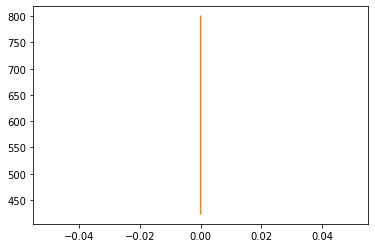

t = 0, loss = 173.33468627929688, SCI_DROPOUT = [0.41181666], SCI_SGD_MOMENTUM = 0.48276662826538086, SCI_BATCH_SIZE = [[227.99905]], SCI_L_SECOND = [[94.99905]], SCI_optimizer = [[7.9991417]], SCI_loss_type = [[2.999428]], SCI_LR = [0.69379395]
SCI_LR:  0.2312646508216858
SCI_LR type:  <class 'float'>
*** LOSS ******: 2
*********  MMLoss
LOSS FUNCTION IS:  MultiMarginLoss()
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.2312646508216858
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.1
Nodes:  94
LR:  0.2312646508216858
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.03
BATCH_SIZE:  227
Dropout:  0.20590832829475403
Final Linear Layers:  2
Class:  0  accuracy:  tensor(0.5752)
Class:  0  correct:  287.0
Class:  1  accuracy:  tensor(0.3700)
Class:  1  correct:  37.0
Final percentage:  tensor(0.4726)
Last epoch:  21


Credit Cost:  tensor([[527.3347]], grad_fn=<AddBackward0>)
Best Score So Far:  tensor([[-423.3347]], grad_fn=<NegBackward>)

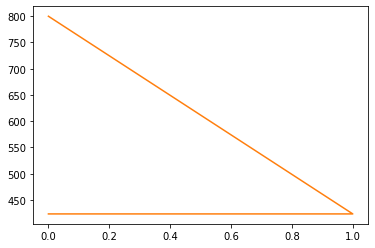

t = 1, loss = 277.334716796875, SCI_DROPOUT = [0.4118071], SCI_SGD_MOMENTUM = 0.4826766550540924, SCI_BATCH_SIZE = [[227.9981]], SCI_L_SECOND = [[94.99809]], SCI_optimizer = [[7.99828]], SCI_loss_type = [[2.9988534]], SCI_LR = [0.69379395]
SCI_LR:  0.2312646508216858
SCI_LR type:  <class 'float'>
*** LOSS ******: 2
*********  MMLoss
LOSS FUNCTION IS:  MultiMarginLoss()
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.2312646508216858
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.1
Nodes:  94
LR:  0.2312646508216858
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.03
BATCH_SIZE:  227
Dropout:  0.2059035450220108
Final Linear Layers:  2
Class:  0  accuracy:  tensor(0.4569)
Class:  0  correct:  228.0
Class:  1  accuracy:  tensor(0.3700)
Class:  1  correct:  37.0
Final percentage:  tensor(0.4135)
Last epoch:  21


Credit Cost:  tensor([[586.3347]], grad_fn=<AddBackward0>)
Best Score So Far:  tensor([[-423.3347]], grad_fn=<NegBackward>)


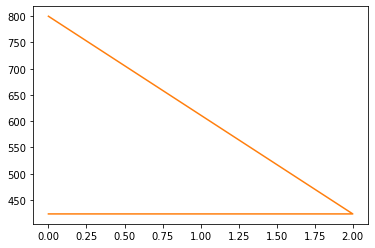

t = 2, loss = 336.33465576171875, SCI_DROPOUT = [0.4117975], SCI_SGD_MOMENTUM = 0.48258668184280396, SCI_BATCH_SIZE = [[227.99713]], SCI_L_SECOND = [[94.99713]], SCI_optimizer = [[7.997415]], SCI_loss_type = [[2.998277]], SCI_LR = [0.69379395]
SCI_LR:  0.2312646508216858
SCI_LR type:  <class 'float'>
*** LOSS ******: 2
*********  MMLoss
LOSS FUNCTION IS:  MultiMarginLoss()
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.2312646508216858
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.1
Nodes:  94
LR:  0.2312646508216858
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.03
BATCH_SIZE:  227
Dropout:  0.20589874684810638
Final Linear Layers:  2
Class:  0  accuracy:  tensor(0.4449)
Class:  0  correct:  222.0
Class:  1  accuracy:  tensor(0.4700)
Class:  1  correct:  47.0
Final percentage:  tensor(0.4574)
Last epoch:  21


Credit Cost:  tensor([[542.3347]], grad_fn=<AddBackward0>)
Best Score So Far:  tensor([[-423.3347]], grad_fn=<NegBackward>)


KeyboardInterrupt: 

In [5]:
if OPTIMIZATION_PLUGIN == 'GradDescent' :
    import pandas as pd
    import matplotlib.pyplot as plt
    import torch
    import torch.optim as optim
    from torch.autograd import Variable
    from Utillities import Utillities
    from cnn_model import CNN6      

    #SCI_LR = 0.2
    SCI_REGULARIZATION = 0.03
    SCI_EPOCHS = 200
    SCI_RELU = 'True'
    SCI_BIAS = 'True'
    SCI_BN_MOMENTUM = 0.1
    
    
    SCI_loss_type = torch.randint(3, 4, (1,1), dtype=torch.float, requires_grad=True) 
    print('SCI_loss_type: ',SCI_loss_type)    
    SCI_SGD_MOMENTUM = torch.rand(1, requires_grad=True)
    print('SCI_SGD_MOMENTUM: ', SCI_SGD_MOMENTUM)
    SCI_BATCH_SIZE   = torch.randint(128, 256, (1,1), dtype=torch.float, requires_grad=True) 
    print('SCI_BATCH_SIZE: ',SCI_BATCH_SIZE)
    SCI_L_SECOND   = torch.randint(80, 96, (1,1), dtype=torch.float, requires_grad=True) 
    print('SCI_L_SECOND: ',SCI_L_SECOND)
    SCI_optimizer   = torch.randint(6, 11, (1,1), dtype=torch.float, requires_grad=True) 
    print('SCI_optimizer: ',SCI_optimizer)    
    SCI_DROPOUT      = torch.rand(1, requires_grad=True)    
    print('SCI_DROPOUT: ',SCI_DROPOUT)   
    SCI_LR      = torch.rand(1, requires_grad=True)    
    print('SCI_LR: ',SCI_LR) 
    

    def objective(SCI_SGD_MOMENTUM, SCI_DROPOUT, SCI_BATCH_SIZE, SCI_L_SECOND, SCI_optimizer, LINEARITY, SCI_loss_type, SCI_LR):
        global SCI_REGULARIZATION, SCI_EPOCHS, SCI_RELU
        global SCI_BIAS, SCI_BN_MOMENTUM, device, MaxCredit, count, CreditVector, CreditVec
        
        SCI_SGD_MOMENTUM = SCI_SGD_MOMENTUM/10
        DROPOUT = (SCI_DROPOUT/2).item()
        if SCI_DROPOUT < 0 :
            DROPOUT = 0
            
        if SCI_BATCH_SIZE < 2 :
            SCI_BATCH_SIZE = 64            

        BATCH_SIZE = int(SCI_BATCH_SIZE)
        
        if SCI_L_SECOND < 4 :
            SCI_L_SECOND = 64
            
        
        L_SECOND = int(SCI_L_SECOND)
        
        def create_loss(LOSS):   
            print('*** LOSS ******:',  LOSS)
            if LOSS == 1:
                loss_func = nn.CrossEntropyLoss()
                print('*********  CrossEntropyLoss')
            if LOSS == 2:
                loss_func = nn.MultiMarginLoss()
                print('*********  MMLoss')                               
            if LOSS == 3:
                loss_func = nn.NLLLoss() 
                print('*********  NLLLoss')                 
            return loss_func

        SCI_LR = SCI_LR.item() / 3
        print('SCI_LR: ', SCI_LR)
        print('SCI_LR type: ', type(SCI_LR))


        
        loss_type = int(SCI_loss_type)
        loss_func = create_loss(loss_type)
        print('LOSS FUNCTION IS: ',loss_func)

        REGULARIZATION = float(str(SCI_REGULARIZATION))

        cnn = CNN6(L_FIRST, L_SECOND, KERNEL_X, SCI_BIAS, SCI_BN_MOMENTUM, SCI_RELU, DROPOUT, dataset.CLASSES, LINEARITY)     

        optimizer1 = Utillities.optimization_algorithms(SCI_optimizer.detach().numpy(),cnn, SCI_LR, SCI_SGD_MOMENTUM, SCI_REGULARIZATION)
        
        if GPU_SELECT == 2:
            if torch.cuda.device_count() > 1:
                cnn = nn.DataParallel(cnn,device_ids=[0, 1], dim=0) 
            cnn = cnn.cuda()
        if GPU_SELECT == 1:
            cnn.to(device)  
        if GPU_SELECT == 0:
            cnn.to(device)        

        cnn.apply(CNN6.weights_reset)
        cnn.share_memory()


        train_losses = []         # to track the training loss as the model trains
        output = 0
        loss = 0
        accuracy = 0
        early_stopping.counter = 0
        early_stopping.best_score = None
        early_stopping.early_stop = False
        early_stopping.verbose = False  
        TEST_RESULTS = torch.zeros(1,2)

    
        Utillities.listing(optimizer1, SCI_SGD_MOMENTUM, SCI_BN_MOMENTUM, L_SECOND, SCI_LR, SCI_RELU, SCI_BIAS, loss_type, REGULARIZATION, BATCH_SIZE, DROPOUT, LINEARITY)

        train_loader = Data.DataLoader(dataset = dataset.train_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = 0, drop_last=True, pin_memory=True)
        validation_loader = Data.DataLoader(dataset = dataset.validation_dataset, batch_size = 144, shuffle = False, num_workers = 0, drop_last=True, pin_memory=True)    
        test_loader = Data.DataLoader(dataset = dataset.test_dataset, batch_size = 599, shuffle = False, num_workers = 0, pin_memory=True, drop_last=True)
    
        for epoch in range(SCI_EPOCHS):
            loss = None        
            cnn.train().cuda()
            for step, (train_data, train_target) in enumerate(train_loader):   
                train_data, train_target = train_data.to(device), train_target.to(device)
                output, temp = cnn(train_data)                   
                loss = loss_func(output, train_target)
                train_losses.append(loss.item())            
                loss.backward()                             
                optimizer1.zero_grad()
                optimizer1.step()                           
      
            cnn.eval().cuda()                   
            valid_loss = 0
            accuracy = 0
            with torch.no_grad():
                for step, (validation_data, validation_target) in enumerate(validation_loader):
                    validation_data, validation_target = validation_data.to(device), validation_target.to(device)
                    output, temp = cnn(validation_data)            # forward pass: compute predicted outputs by passing inputs to the model
                    valid_loss += loss_func(output, validation_target).item()  
               
            train_losses = []
            early_stopping(valid_loss, cnn)
       
            if early_stopping.early_stop:
                if os.path.exists('checkpoint.pt'):
                    print("Loaded the model with the lowest Validation Loss!")
                    cnn.load_state_dict(torch.load('checkpoint.pt', map_location="cuda:1"))  # Choose whatever GPU device number you want
                    cnn.to(device)
                break
      
        cnn.eval()
        class_correct = list(0. for i in range(1000))
        class_total = list(0. for i in range(1000))
        with torch.no_grad():
            for (test_data, test_target) in test_loader:
                test_data, test_target = test_data.to(device), test_target.to(device)
                outputs, temp = cnn(test_data)
                _, predicted = torch.max(outputs, 1)
                c = (predicted == test_target).squeeze()
                for i in range(test_target.size(0)):
                    label = test_target[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1

        for i in range(dataset.CLASSES):
            TEST_RESULTS[0,i] = class_correct[i] / dataset.TESTED_ELEMENTS[i]
            print('Class: ',i,' accuracy: ', TEST_RESULTS[0,i])
            print('Class: ',i,' correct: ', class_correct[i])
        percent = (TEST_RESULTS[0,0]+TEST_RESULTS[0,1])/2
        print('Final percentage: ',percent)
    
        CreditCost = (1 - TEST_RESULTS[0,0]) * dataset.TESTED_ELEMENTS[0] + (1 - TEST_RESULTS[0,1]) * dataset.TESTED_ELEMENTS[1] * 5
    
        if TEST_RESULTS[0,0] == 0 or TEST_RESULTS[0,1] == 0 :
            CreditCost = CreditCost + 300
    
        print('Last epoch: ', epoch)
   
        if os.path.exists('checkpoint.pt'):  
            os.remove('checkpoint.pt') 

        print()
        torch.cuda.empty_cache()
        print()
        
        CreditCost = CreditCost + (SCI_SGD_MOMENTUM + SCI_DROPOUT + SCI_BATCH_SIZE + SCI_L_SECOND + SCI_optimizer + SCI_loss_type+ SCI_LR)/1000
        print('Credit Cost: ',CreditCost)
        
        
        if -CreditCost > MaxCredit : 
            MaxCredit = -CreditCost
        print('Best Score So Far: ',MaxCredit)   
        
        CreditVector[count] = MaxCredit    
        CreditVec[count] = count
        # plot the data
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(CreditVec, -CreditVector, color='tab:orange')
        #print(CreditVec, -CreditVector)
        count = count + 1
        # display the plot
        plt.show()
             
        return CreditCost

    
    def loss(y_predicted, expected):
        return (y_predicted - expected).sum()
            
    
    expected = 250
    
    optim_alg = optim.Adadelta([       
        {'params': SCI_SGD_MOMENTUM, 'lr': 0.9},
        {'params': SCI_DROPOUT, 'lr': 1e-2},
        {'params': SCI_BATCH_SIZE, 'lr': 1},
        {'params': SCI_L_SECOND, 'lr': 1},
        {'params': SCI_optimizer, 'lr': 0.9},
        {'params': SCI_loss_type, 'lr': 0.6}, 
        {'params': SCI_LR, 'lr': 0.1}   
        ]) 
    
    LINEARITY = 2
    # Main optimization loop
    for t in range(RANDOM_STARTS + TRIALS):
        optim_alg.zero_grad()
        y_predicted = objective(SCI_SGD_MOMENTUM, SCI_DROPOUT, SCI_BATCH_SIZE, SCI_L_SECOND, SCI_optimizer, LINEARITY, SCI_loss_type, SCI_LR)
        current_loss = loss(y_predicted, expected)
        current_loss.backward()
        optim_alg.step()
        print(f"t = {t}, loss = {current_loss}, SCI_DROPOUT = {SCI_DROPOUT.detach().numpy()}, SCI_SGD_MOMENTUM = {SCI_SGD_MOMENTUM.item()}, SCI_BATCH_SIZE = {SCI_BATCH_SIZE.detach().numpy()}, SCI_L_SECOND = {SCI_L_SECOND.detach().numpy()}, SCI_optimizer = {SCI_optimizer.detach().numpy()}, SCI_loss_type = {SCI_loss_type.detach().numpy()}, SCI_LR = {SCI_LR.detach().numpy()}")
    

In [ ]:
end.record()

#print('Minimum Credit Cost: ',Min_Credit_Cost)

print()
print('Total execution time (minutes): ',start.elapsed_time(end)/60000)

torch.cuda.empty_cache()

if GET_STATS:
    pr.disable()
    s = io.StringIO()
    sortby = SortKey.CUMULATIVE
    ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
    ps.print_stats()
    print(s.getvalue())